## 1. Construct the Hamiltonian Matrix 

In [42]:
import numpy as np 
import matplotlib.pyplot as plt

In [43]:
def flip_operator(i):
  if i==1:
    return 0
  elif i==0:
    return 1

In [44]:
# Matrix Construction

def matrix_construction(h,N):

  dimension=2**N

  #spin chain with all spin-down
  z='0'*N

  # initialize hamiltonian
  H=np.zeros((dimension,dimension),dtype=np.dtype('f4'))

  for a in range(dimension): 
    J = 1
    state_chain=bin(a)[2:] 
    l=len(state_chain)
    state_chain=z[0:N-l]+state_chain
    #print(state_chain)

    for i in range(N): 
      j=np.mod(i+1,N) 
      #1. For the -S^Z_(i) S^Z_(i+1) operator 
      if state_chain[i]==state_chain[j]: 
        H[a,a]+=-1
      else:                            
        H[a,a]+=1 
    
      #2. For the (-h)*(S+_{i} + S-_{i}) operator
      element_at_i = int(state_chain[i])
      flipped_element_at_i = flip_operator(element_at_i)
      flipped_state_chain = str(state_chain[:i]+str(flipped_element_at_i)+state_chain[i+1:])
      b = int(flipped_state_chain,2)
      H[a,b]+=-h
  
  return H

In [45]:
h = 1
L = 10

In [46]:
H = matrix_construction(h,L)
eig_value=np.real(np.linalg.eig(H)[0])# eigenvalues
eig_vec=np.real(np.linalg.eig(H)[1]) # eigenstates

idx_sorted1 = np.argsort(eig_value)
eig_value = eig_value[idx_sorted1][:50]
eig_vec = eig_vec[:,idx_sorted1]
eig_value_normalized = eig_value - eig_value[0]

np.save(f"eig_value_of_{L}_at_{h}",eig_value_normalized) # store the normalized eigenvalues
np.save(f"eig_vec_of_{L}_at_{h}",eig_vec) # store the eigenvector 
#print(H)


The eigenvector is the column of the the variables eig_vec. Therefore, in order to obtain the ground state(0th state), we use eig_vec[:,0] (or accessing i-th state, we use eig_vec[:,i])

In [47]:
print(eig_vec[:,0])

[-0.41058427 -0.11434388 -0.11434388 ... -0.11434388 -0.11434388
 -0.41058427]


## 2. Calculate the Renyi Entropy 

The following function is used to calculate Renyi Entropy (Thank you Wang for giving me this function)

In [48]:
def cal_renyi(psi,si,L,order):
  size1 = 2**(si)
  size2 = 2**(L-si)
  psi = psi.reshape((size1,size2))
  #reduced density matrix
  rho_r = psi@psi.T
  #print(rho_r)
  #print(np.linalg.eig(rho_r)[0])
  prob = np.linalg.eig(rho_r)[0]/np.trace(rho_r)
  #print(prob)
  renyi = (1/(1-order))*np.log(np.sum(prob**order))
  return renyi


In [49]:
print(cal_renyi(eig_vec[:,0],int(L/2),L,2))

0.5115873217582703


In [50]:
def cal_renyi_new(psi, si, L, order):
    size1 = 2**si
    size2 = 2**(L-si)
    psi = psi.reshape((size1, size2))
    rho_r = psi @ psi.T
    prob = np.linalg.eigvalsh(rho_r) / np.trace(rho_r)
    renyi = (1 / (1 - order)) * np.log(np.sum(prob**order))
    return renyi

In [51]:
Renyi_S = []
for i in range(1,L):
    Renyi_S.append(cal_renyi(eig_vec[:,0],i,L,2))
np.save(f"RenyiEntropyOfSize{L}from1to{L-1}",Renyi_S) 

In [52]:
Renyi_S_L4 = np.load(f"RenyiEntropyOfSize4from1to3.npy")
Renyi_S_L6 = np.load(f"RenyiEntropyOfSize6from1to5.npy")
Renyi_S_L10 = np.load(f"RenyiEntropyOfSize10from1to9.npy")
print(Renyi_S_L4)
print(Renyi_S_L6)
print(Renyi_S_L10)

[0.33772936 0.38646051 0.33772936]
[0.34624946+0.j 0.42295176+0.j 0.44270775+0.j 0.42295149+0.j
 0.34624922-0.j]
[0.3505266 +0.j 0.43993753+0.j 0.4832609 +0.j 0.50490826+0.j
 0.51158732+0.j 0.50490808+0.j 0.48326099+0.j 0.43993735+0.j
 0.35052645-0.j]


In [64]:
from scipy.optimize import curve_fit
import numpy as np
def formulaFromCFT(x,k):
    """
    This function is defined for the fitting 
    x = subsystem size/system size

    """
    return (0.5)/3*np.log((L/np.pi)*np.sin(np.pi*x))+k

In [65]:
parametersL4, pcovL4 = curve_fit(formulaFromCFT,[i/4 for i in range(1,4)],Renyi_S_L4)
parametersL6, pcovL6 = curve_fit(formulaFromCFT,[i/6 for i in range(1,6)],Renyi_S_L6)
parametersL10, pcovL10 = curve_fit(formulaFromCFT,[i/10 for i in range(1,10)],Renyi_S_L10)

c:\Users\timch\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


c:\Users\timch\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


[0.25904528]


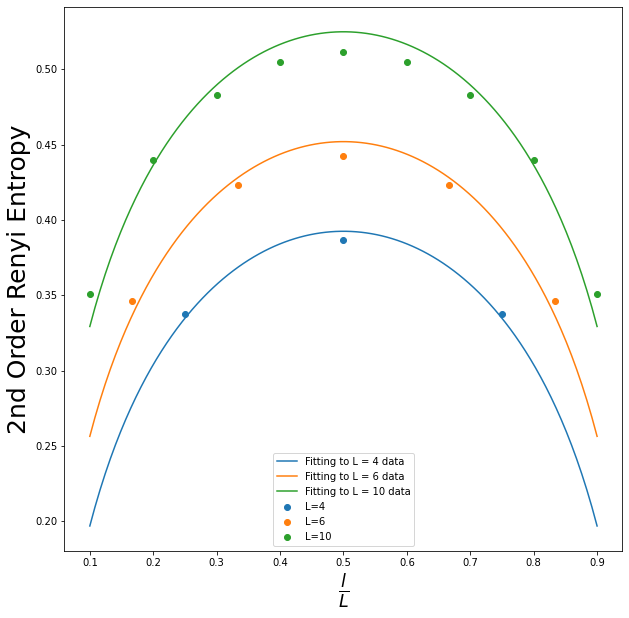

In [66]:
plt.figure(figsize=(10,10))

plt_array = np.linspace(0.1,0.9,100)

plt.scatter([i/4 for i in range(1,4)],Renyi_S_L4,label="L=4")
plt.scatter([i/6 for i in range(1,6)],Renyi_S_L6,label="L=6")
plt.scatter([i/10 for i in range(1,10)],Renyi_S_L10,label="L=10")

plt.plot(plt_array, formulaFromCFT(plt_array, *parametersL4), label="Fitting to L = 4 data")
plt.plot(plt_array, formulaFromCFT(plt_array, *parametersL6), label="Fitting to L = 6 data")
plt.plot(plt_array, formulaFromCFT(plt_array, *parametersL10), label="Fitting to L = 10 data")

plt.ylabel("2nd Order Renyi Entropy",size=25)
plt.xlabel(r"$\frac{l}{L}$",size=25)
plt.legend()

print()

print(parametersL6)
#plt.savefig("S versus (l over L)(Exact diagonlization)")

In [23]:
Renyi_S_L12 = np.zeros(L-3)
for i in range(2,L-1):
    Renyi_S_L12[i-2] = cal_renyi(eig_vec[:,0],i,L,2)
np.save(f"RenyiEntropyOfSize{L}from2to{L-1}",Renyi_S_L12) 

In [38]:
Renyi_S_L10 = np.zeros(L-3)
for i in range(2,L-1):
    Renyi_S_L10[i-2] = cal_renyi(eig_vec[:,0],i,L,2)
np.save(f"RenyiEntropyOfSize{L}from2to{L-1}",Renyi_S_L10) 

## 3. Load the data and plot the graph

In [ ]:
Renyi_S_L10 = np.load(f"RenyiEntropyOfSize4from.npy")

In [40]:
Renyi_S_L10 = np.load(f"RenyiEntropyOfSize10from2to9.npy")
Renyi_S_L12 = np.load(f"RenyiEntropyOfSize12from2to11.npy")
print(Renyi_S_L12)
print(Renyi_S_L10)

[0.44275749 0.48966277 0.51669502 0.53114045 0.53571236 0.53114045
 0.51669502 0.48966277 0.44275749]
[0.43993738 0.48326087 0.50490826 0.5115872  0.50490808 0.48326087
 0.43993738]


Plot the graph $S_A^{(2)}$ versus $ln(L/\pi sin(\pi l/L))$

In [43]:
L_10_x_array = np.log(10/(np.pi)*np.sin(np.pi*np.arange(2,9)/10))
L_12_x_array = np.log(12/(np.pi)*np.sin(np.pi*np.arange(2,11)/12))

Text(0.5, 0, '$ln(\\frac{L}{\\pi}sin(\\pi \\frac{l}{L}))$')

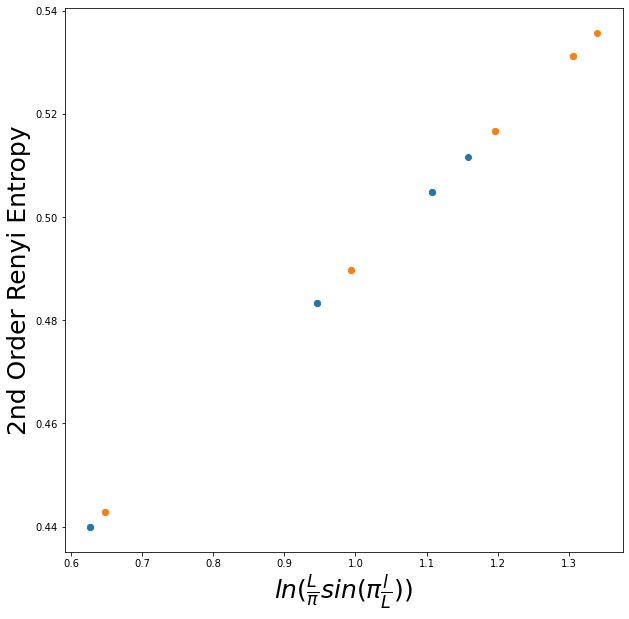

In [54]:
plt.figure(figsize=(10,10))
plt.scatter(L_10_x_array,Renyi_S_L10,label="L=10")
plt.scatter(L_12_x_array,Renyi_S_L12,label="L=12")
plt.ylabel("2nd Order Renyi Entropy",size=25)
plt.xlabel(r"$ln(\frac{L}{\pi}sin(\pi \frac{l}{L}))$",size=25)
plt.legend()

Fitting to the data

In [56]:
from scipy.optimize import curve_fit

In [79]:
def formulaFromCFT(x,k):
    """
    This function is defined for the fitting 

    """
    return (0.5)/3*x+k

In [80]:
parametersL10, pcovL10 = curve_fit(formulaFromCFT, L_10_x_array, Renyi_S_L10)
parametersL12, pcovL12 = curve_fit(formulaFromCFT, L_12_x_array, Renyi_S_L12)

print(parametersL10)
print(parametersL12)

[0.32592465]
[0.32133726]


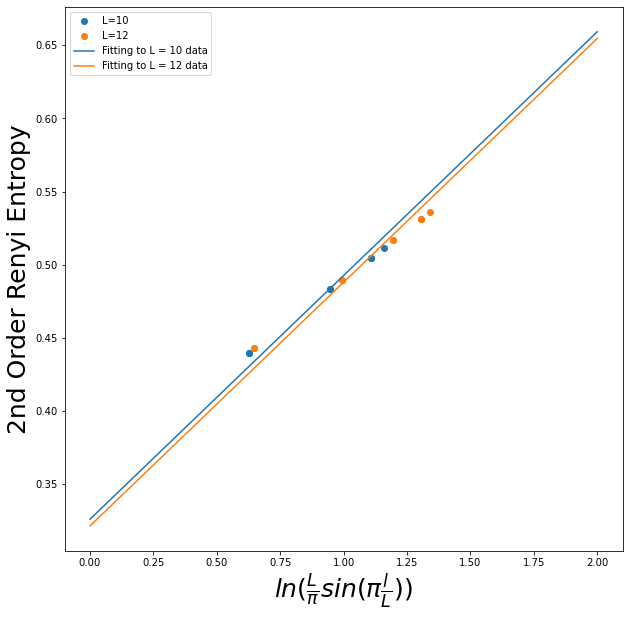

In [81]:
plt_array = np.linspace(0,2,100)
plt.figure(figsize=(10,10))
plt.scatter(L_10_x_array,Renyi_S_L10,label="L=10")
plt.scatter(L_12_x_array,Renyi_S_L12,label="L=12")
plt.plot(plt_array, formulaFromCFT(plt_array, *parametersL10), label="Fitting to L = 10 data")
plt.plot(plt_array, formulaFromCFT(plt_array, *parametersL12), label="Fitting to L = 12 data")
#plt.plot(plt_array,formulaFromCFT(plt_array, 1/2, parametersL10[0]),label="Theoretical prediction from CFT")


plt.ylabel("2nd Order Renyi Entropy",size=25)
plt.xlabel(r"$ln(\frac{L}{\pi}sin(\pi \frac{l}{L}))$",size=25)
plt.legend()